In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
meta_df = pd.read_csv(r"..\OneDrive\Desktop\Covid\metadata.csv", dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

C:\Users\jaaye\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [3]:
all_json = glob.glob(r'C:\Users\jaaye\OneDrive\Desktop\Covid\**\*.json', recursive=True)
len(all_json)

71261

In [4]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])

In [12]:
first_row

003d2e515e1aaf06f0052769953e861ed8e56608: ... It is highly contagious, and severe cases can lead to acute respiratory distress or multiple organ failure [3] . On 11 March 2020, the WHO has made the assessment that COVID-19 can be characterised as...

In [5]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [32]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 71261
Processing index: 7126 of 71261
Processing index: 14252 of 71261
Processing index: 21378 of 71261
Processing index: 28504 of 71261
Processing index: 35630 of 71261
Processing index: 42756 of 71261
Processing index: 49882 of 71261
Processing index: 57008 of 71261
Processing index: 64134 of 71261
Processing index: 71260 of 71261


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,003d2e515e1aaf06f0052769953e861ed8e56608,NaN,,"It is highly contagious, and severe cases can ...",Shaoping Hu. Yuan Gao. Zhangming Niu. Ying...,Weakly Supervised Deep Learning for COVID-19<...,NaN,Not provided.
1,00a407540a8bdd6d7425bd8a561eb21d69682511,NaN,Rapidly developed AI-based automated CT image ...,• For Coronavirus patients the system outputs ...,Ophir Gozes. Maayan Frid-Adar. Hayit<br>Gre...,Rapid AI Development Cycle for the Coronaviru...,NaN,Rapidly developed AI-based automated CT image...
2,00c386ee8b9fac7eeb2291a72d52966d83eec814,NaN,It is shown that the evaporation rate of a liq...,It is shown that the evaporation rate of a liq...,P. Grinchuk S.. E. Fisenko I.. S. Fisenko P...,Isothermal evaporation rate of deposited<br>l...,NaN,It is shown that the evaporation rate of a li...
3,024b30561568979f525d8b2580f85122c02008a0,NaN,A model of reactive social distancing in epide...,Let the proportions of a population who are su...,Rose Baker,Reactive Social distancing in a SIR model of<...,NaN,A model of reactive social distancing in<br>e...
4,02b3c0c87a6b32d5107a6e05f83f73cb7f939432,NaN,Large scale disease screening is a complicated...,In many cohort studies specimens collected fro...,Gregory Haber. Yaakov Malinovsky. Paul Albe...,Is Group Testing Ready for Prime-time in<br>D...,NaN,Large scale disease screening is a complicate...


In [33]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,003d2e515e1aaf06f0052769953e861ed8e56608,NaN,,"It is highly contagious, and severe cases can ...",Shaoping Hu. Yuan Gao. Zhangming Niu. Ying...,Weakly Supervised Deep Learning for COVID-19<...,NaN,Not provided.,0,4007,1408
1,00a407540a8bdd6d7425bd8a561eb21d69682511,NaN,Rapidly developed AI-based automated CT image ...,• For Coronavirus patients the system outputs ...,Ophir Gozes. Maayan Frid-Adar. Hayit<br>Gre...,Rapid AI Development Cycle for the Coronaviru...,NaN,Rapidly developed AI-based automated CT image...,102,2060,819
2,00c386ee8b9fac7eeb2291a72d52966d83eec814,NaN,It is shown that the evaporation rate of a liq...,It is shown that the evaporation rate of a liq...,P. Grinchuk S.. E. Fisenko I.. S. Fisenko P...,Isothermal evaporation rate of deposited<br>l...,NaN,It is shown that the evaporation rate of a li...,119,3140,943
3,024b30561568979f525d8b2580f85122c02008a0,NaN,A model of reactive social distancing in epide...,Let the proportions of a population who are su...,Rose Baker,Reactive Social distancing in a SIR model of<...,NaN,A model of reactive social distancing in<br>e...,53,952,426
4,02b3c0c87a6b32d5107a6e05f83f73cb7f939432,NaN,Large scale disease screening is a complicated...,In many cohort studies specimens collected fro...,Gregory Haber. Yaakov Malinovsky. Paul Albe...,Is Group Testing Ready for Prime-time in<br>D...,NaN,Large scale disease screening is a complicate...,1255,4439,1121


In [34]:
df_covid['abstract'].describe(include='all')

count     43331
unique    30960
top            
freq      12271
Name: abstract, dtype: object

In [35]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     43299
unique    30960
top            
freq      12254
Name: abstract, dtype: object

In [36]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,43299.000000,43299.000000,43299.000000
mean,157.312340,4529.258643,1377.094714
std,174.910323,7065.767658,1188.978218
min,0.000000,1.000000,1.000000
25%,0.000000,2179.000000,846.000000
50%,153.000000,3485.000000,1194.000000
75%,233.000000,5269.000000,1635.000000
max,5370.000000,268982.000000,38298.000000


In [37]:
#rename to df for ease of use
df = df_covid.sample(10000, random_state=42)
del df_covid

In [38]:
df.dropna(inplace=True)

In [23]:
pip install langdetect

  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993196 sha256=141ac6a755445e37ff5373ca6074e7dffdf4f2e885c343e6805db3ff885e427a
  Stored in directory: c:\users\jaaye\appdata\local\pip\cache\wheels\59\f6\9d\85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [39]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████████████████████████████████████████████████████████████████████████| 8927/8927 [02:04<00:00, 71.81it/s]


In [40]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8927

{'af': 1,
 'ca': 1,
 'cy': 2,
 'de': 25,
 'en': 8685,
 'es': 103,
 'fr': 89,
 'it': 5,
 'nl': 12,
 'pt': 3,
 'ro': 1}


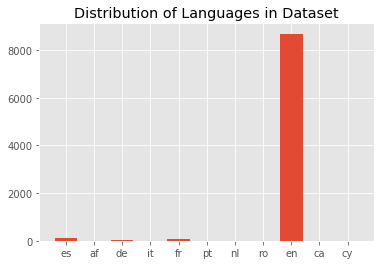

In [41]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [42]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 12404 to 21883
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             8685 non-null   object
 1   doi                  8685 non-null   object
 2   abstract             8685 non-null   object
 3   body_text            8685 non-null   object
 4   authors              8685 non-null   object
 5   title                8685 non-null   object
 6   journal              8685 non-null   object
 7   abstract_summary     8685 non-null   object
 8   abstract_word_count  8685 non-null   int64 
 9   body_word_count      8685 non-null   int64 
 10  body_unique_words    8685 non-null   int64 
 11  language             8685 non-null   object
dtypes: int64(3), object(9)
memory usage: 882.1+ KB


In [47]:
from IPython.utils import io

with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz  

In [43]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [44]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['myself',
 'whereafter',
 'afterwards',
 'these',
 'please',
 'so',
 'except',
 'since',
 'twenty',
 'what']

In [45]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [46]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [48]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

C:\Users\jaaye\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████████| 8685/8685 [2:33:18<00:00,  1.06s/it]


In [49]:
import seaborn as sns

count      8685.000000
mean       4468.734830
std        5375.443656
min          13.000000
25%        2339.000000
50%        3611.000000
75%        5342.000000
max      188793.000000
Name: body_word_count, dtype: float64

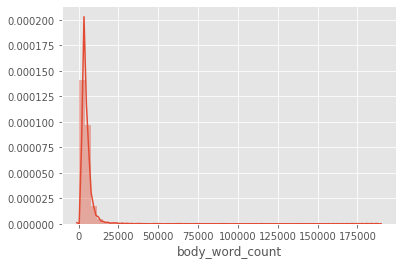

In [50]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     8685.000000
mean      1383.699021
std        961.296124
min         13.000000
25%        891.000000
50%       1231.000000
75%       1657.000000
max      25156.000000
Name: body_unique_words, dtype: float64

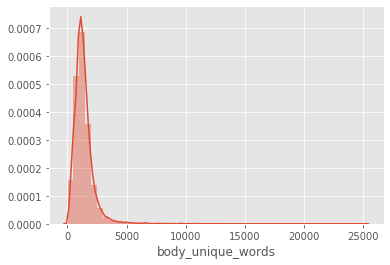

In [51]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [53]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(8685, 4096)

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(8685, 2112)

In [55]:
from sklearn.cluster import KMeans

In [56]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    print(k)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


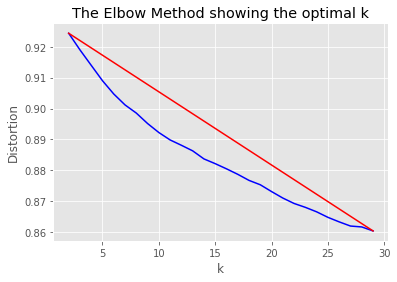

In [57]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [58]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [59]:
y_pred

array([ 6, 10,  5, ..., 11,  0,  5])

In [60]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 8685 samples in 13.896s...
[t-SNE] Computed neighbors for 8685 samples in 534.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8685
[t-SNE] Computed conditional probabilities for sample 2000 / 8685
[t-SNE] Computed conditional probabilities for sample 3000 / 8685
[t-SNE] Computed conditional probabilities for sample 4000 / 8685
[t-SNE] Computed conditional probabilities for sample 5000 / 8685
[t-SNE] Computed conditional probabilities for sample 6000 / 8685
[t-SNE] Computed conditional probabilities for sample 7000 / 8685
[t-SNE] Computed conditional probabilities for sample 8000 / 8685
[t-SNE] Computed conditional probabilities for sample 8685 / 8685
[t-SNE] Mean sigma: 0.375939
[t-SNE] KL divergence after 50 iterations with early exaggeration: 80.763863
[t-SNE] KL divergence after 1000 iterations: 1.816270


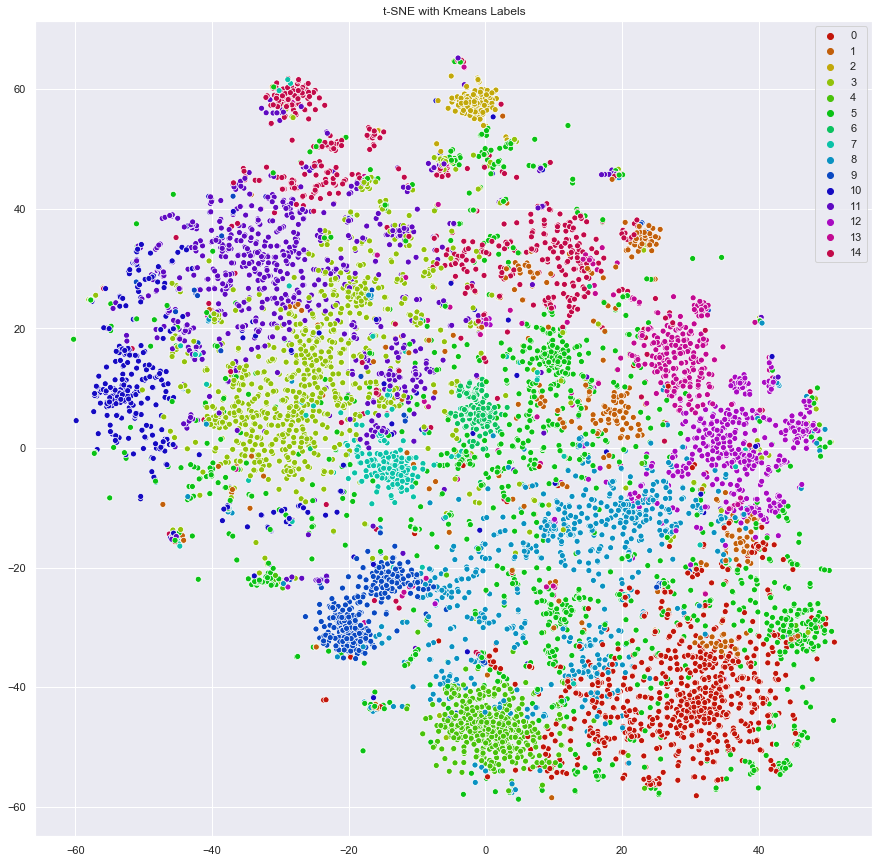

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(15, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.show()

In [96]:
arr1 = np.array(np.reshape(X_embedded[:,0], (8685,1), order='C'))
arr2 = np.array(np.reshape(X_embedded[:,1], (8685,1), order='C'))
arr3 = np.array(np.reshape(y_pred, (8685,1), order='C'))

In [94]:
arr3.shape

(8685, 1)

In [109]:
df1 = pd.DataFrame(np.concatenate(arr1), columns = ['Axis1']);
df1['Axis2'] = arr2;
df1['Kernel'] = arr3;
df1.head()

,Axis1,Axis2,Kernel
0,-1.302243,9.333343,6
1,-50.427853,25.153162,10
2,46.292797,-32.921535,5
3,-26.910439,8.999545,3
4,22.566523,-13.084806,8


In [110]:
df1.to_csv(r"..\OneDrive\Desktop\Covid\Output.csv")